## Import the packages

In [74]:
import os
import openai
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import re
import matplotlib.pyplot as plt

## Set up openai environment variables

In [75]:
load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]
openai.api_type = os.environ["OPENAI_API_TYPE"]
openai.api_base  = os.environ["OPENAI_API_BASE"]
openai.api_version  = os.environ["OPENAI_API_VERSION"]
model_deployment = os.environ["DEPLOYMENT_ID"]

## Load data from the parquet files

In [76]:
df_train = pd.read_parquet('data/biosses_train_0000.parquet')
df_test = pd.read_parquet('data/biosses_test_0000.parquet')

## Define correlation function

In [77]:
def calculate_correlation(example_size,temperature):

    # Create a new column called "model_result"
    df_test["model_score"] = None

    # Build the prompt with examples from the train file
    train_examples = ""
    #for row_number in range(len(df_train)):
    for row_number in range(example_size):

        # Get the row at the current index
        row = df_train.loc[row_number]
        chain = 'The sentence "' + row["sentence1"] +  '" and the sentence "' + row["sentence1"] + '" have a similarity score of  ' + row["score"].astype(str)
        train_examples += chain + "\n"


    system_msg = '''You are a helpful assistant who helps retrieve similarity scores between two sentences.
    You will find below some examples to help you determine this similarity score with the best accuracy :
    ''' + train_examples


    # Iterate over the DataFrame using a for loop with an iteration of the type for row_number in range(number_of_lines)
    for row_number in range(len(df_test)):

        # Get the row at the current index
        row = df_test.loc[row_number]

        # Define the user message
        user_msg = 'Please give me the similarity score from 0.0 to 4.0 between those sentences : "' + row["sentence1"] +  '" and "' + \
                row["sentence2"] + \
                '". Always respond using strictly and only the following format without any justification: Similarity_score : XXX "'

        response = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                            deployment_id= model_deployment,
                                            temperature = temperature,
                                            seed = 42,
                                            messages=[{"role": "system", "content": system_msg}, {"role": "user", "content": user_msg}])


        try:
            # Retrieve similarity score
            final_score = response["choices"][0]["message"]["content"].split(":")[1].strip()
            final_score = re.sub(r'[^\d.]+$', '', final_score).rstrip('.')
            final_score = float(final_score)

            # Store the similarity score in the DataFrame
            df_test.loc[row_number, "model_score"] = final_score

        except Exception as e:
            print(response)
            print(f"An unexpected error occurred for row_number {row_number}")

    # Calculate Person correlation between score and model_score
    correlation_coefficient, _ = pearsonr(df_test['score'], df_test['model_score'])

    return correlation_coefficient, df_test

## Create correlation matrix from temperature and size of train examples variations

In [78]:
# Initialize empty list
correlation_values = []

# Iterate on the number of examples given to the prompt
for example in range(0, 70, 10):
    print("Number of example considered in prompt : ",example)
    row_values = []  # Initialiser une nouvelle ligne pour chaque valeur de k
    for temperature in range(11):
        print("Temperature : ", temperature/10)
        result = calculate_correlation(example, temperature/10)[0]
        row_values.append(result)

    # Ajouter la ligne complète au tableau principal
    correlation_values.append(row_values)

# Create dataframe from list
df_correlation = pd.DataFrame(correlation_values, columns=[f"temp_{temperature/10}" for temperature in range(11)], index=[f"example_{example}" for example in range(0, 70, 10)])



Number of example considered in prompt :  0
Temperature :  0.0
Temperature :  0.1
Temperature :  0.2
Temperature :  0.3
Temperature :  0.4
Temperature :  0.5
Temperature :  0.6
Temperature :  0.7
Temperature :  0.8
Temperature :  0.9
Temperature :  1.0
Number of example considered in prompt :  10
Temperature :  0.0
Temperature :  0.1
Temperature :  0.2
Temperature :  0.3
Temperature :  0.4
Temperature :  0.5
Temperature :  0.6
Temperature :  0.7
Temperature :  0.8
Temperature :  0.9
Temperature :  1.0
Number of example considered in prompt :  20
Temperature :  0.0
Temperature :  0.1
Temperature :  0.2
Temperature :  0.3
Temperature :  0.4
Temperature :  0.5
Temperature :  0.6
Temperature :  0.7
Temperature :  0.8
Temperature :  0.9
Temperature :  1.0
Number of example considered in prompt :  30
Temperature :  0.0
Temperature :  0.1
Temperature :  0.2
Temperature :  0.3
Temperature :  0.4
Temperature :  0.5
Temperature :  0.6
Temperature :  0.7
Temperature :  0.8
Temperature :  0.9
Temp

## Charts of model result similarities

### Temperature charts

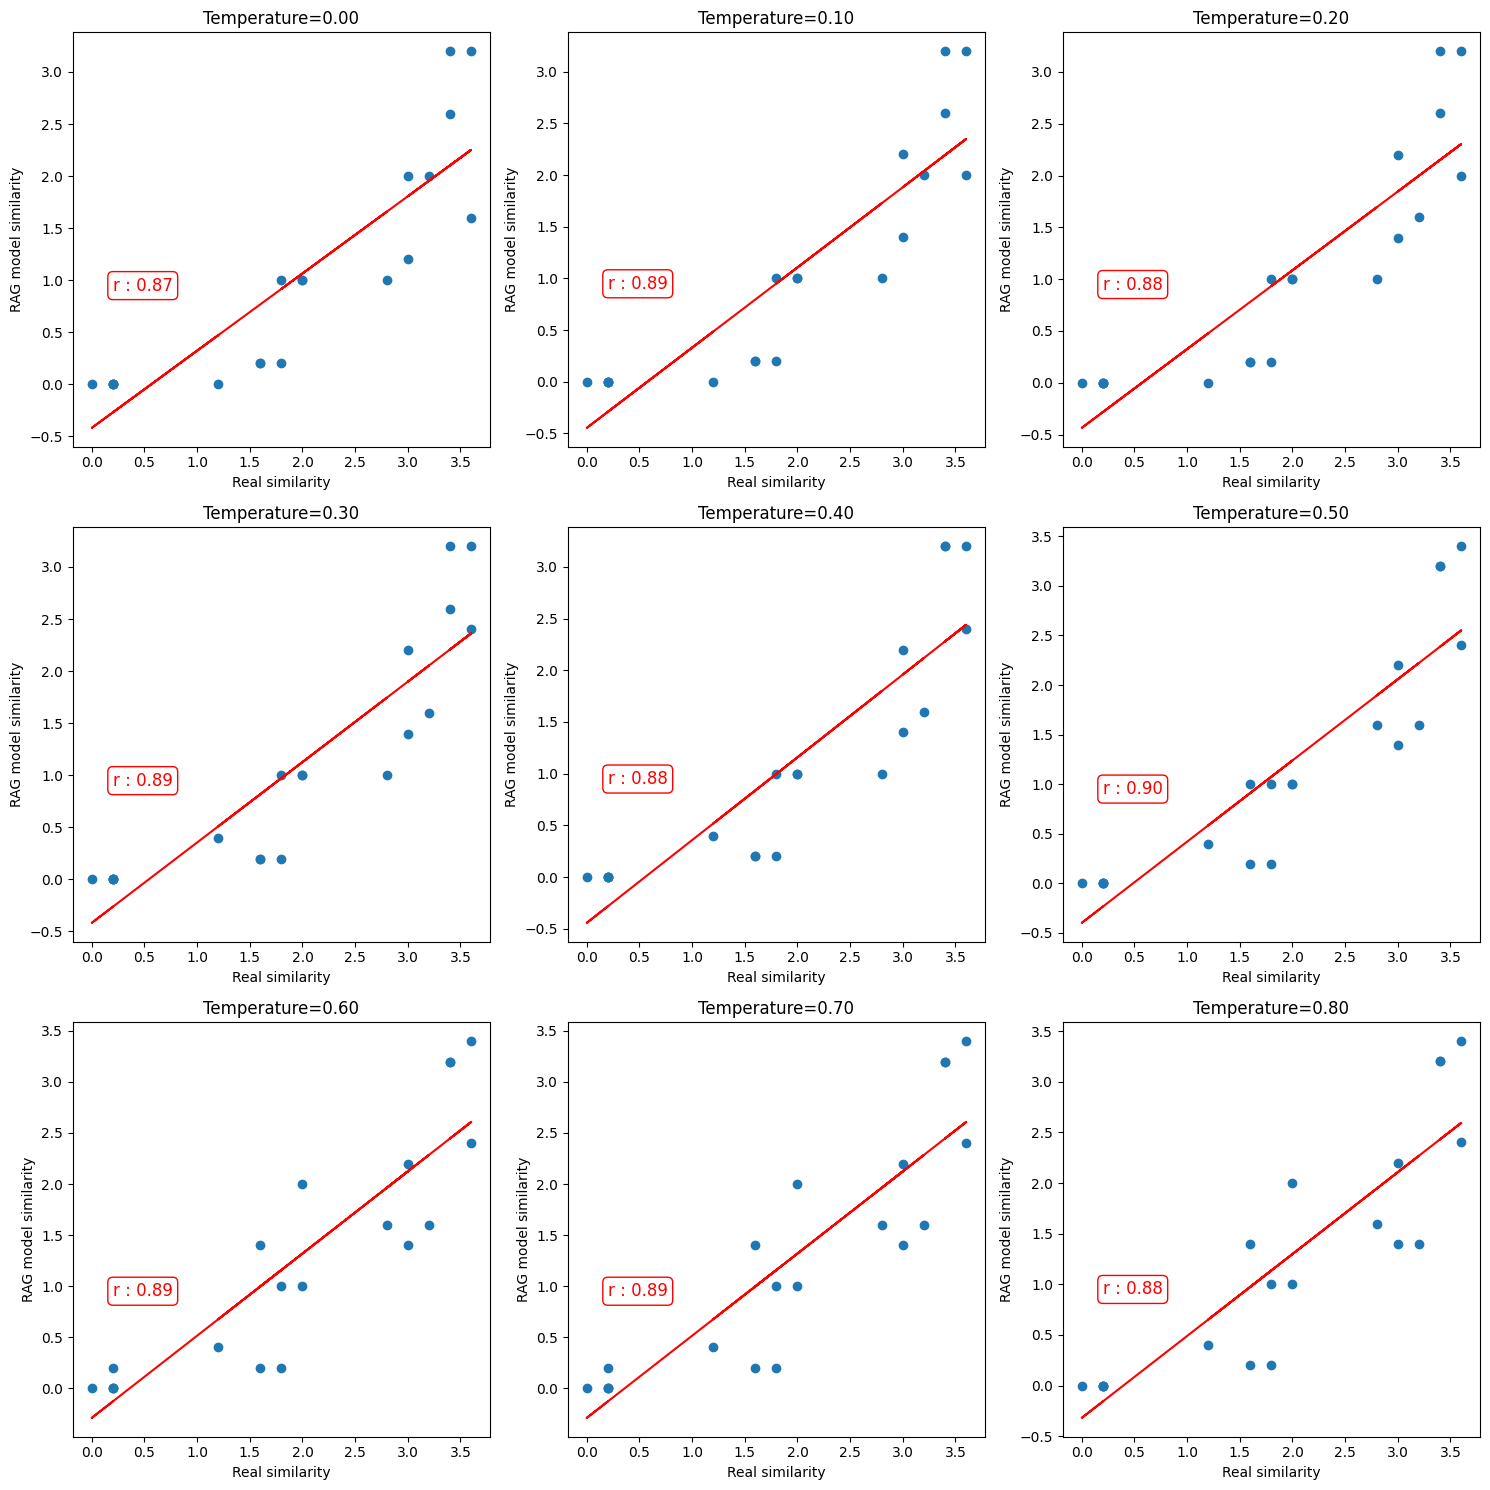

In [71]:

def plot_correlation_graph(ax, example_size, temperature):
    # Call the function to get the DataFrame
    df = calculate_correlation(example_size, temperature)[1]

    # Convert columns to numeric types
    df['score'] = pd.to_numeric(df['score'])
    df['model_score'] = pd.to_numeric(df['model_score'])

    # Calculate linear regression
    coefficients = np.polyfit(df['score'], df['model_score'], 1)
    polynomial = np.poly1d(coefficients)

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(df['score'], df['model_score'])

    # Sort the data by 'model_score'
    df_sorted = df.sort_values(by='model_score')

    # Scatter plot
    ax.scatter(df['score'], df['model_score'])

    # Plot the regression line in red using sorted data
    ax.plot(df_sorted['score'], polynomial(df_sorted['score']), color='red')

    # Display Pearson correlation coefficient as text
    text = f'r : {correlation_coefficient:.2f}'
    ax.text(0.2, 0.9, text, color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'), fontsize=12)

    ax.set_xlabel('Real similarity')
    ax.set_ylabel('RAG model similarity')
    ax.set_title(f'Temperature={temperature:.2f}')

# Create a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Vary the temperature parameter
temperatures = np.arange(0, 1.1, 0.1)

# Fill the grid with plots
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        if index < len(temperatures):
            plot_correlation_graph(axes[i, j], 20, temperatures[index])

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()


### Example size charts

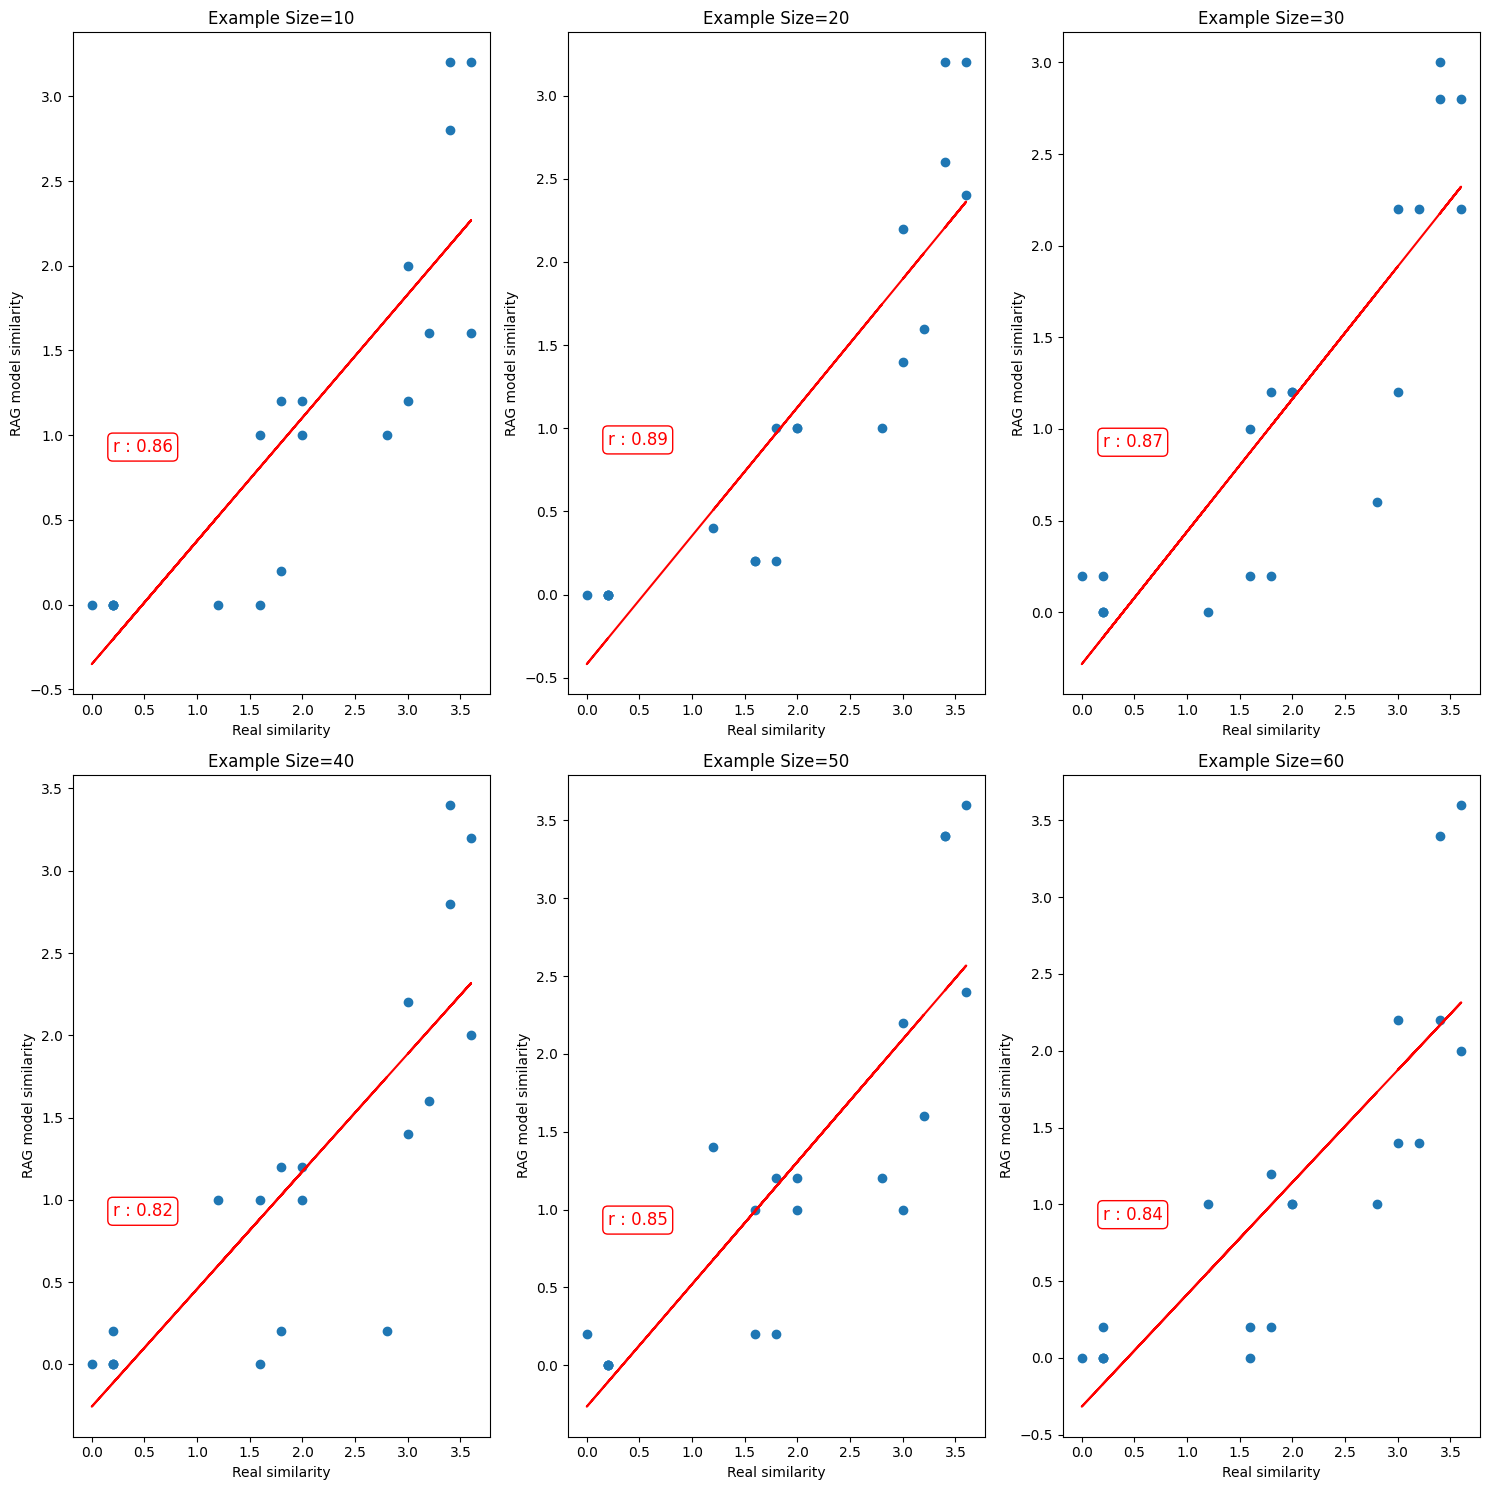

In [72]:
# Create a 3x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 15))

# Vary the example_size parameter
example_sizes = range(10, 61, 10)

# Fill the grid with plots
for i in range(2):
    for j in range(3):
        index = i * 3 + j
        if index < len(example_sizes):
            plot_correlation_graph(axes[i, j], example_sizes[index], 0.3)  # Set a specific temperature, e.g., 0.3

            # Update the title to display example_size
            axes[i, j].set_title(f'Example Size={example_sizes[index]}')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()
